#### Example IRIS code 

This example code computes the WSS for SWORD reach 22791100061 in the same way it is computed for the ICESat-2 River Surface Slope (IRIS)dataset.  
The method is described in detail in https://doi.org/10.1029/2022WR032842.

The input data for IRIS are:
- ATL13: ATLAS/ICESat-2 L3A Along Track Inland Surface Water Data (*Jasinski et al. 2021*)
- SWORD: SWOT Mission River Database (*Altenau et al. 2021*).

##### References
Altenau, E. H. et al. SWOT River Database (SWORD) (Version v1), https://doi.org/10.5281/zenodo.4917236 (2021).  
Jasinski, M. et al. ATLAS/ICESat-2 L3A Inland Water Surface Height, Version 5., https://doi.org/10.5067/ATLAS/ATL13.005 (2021).  

IRIS data is calculated on reach scale using functions of the custom SWORD_Reach class.  
Objects of the SWORD_Reach class are a python representation of the SWORD reach netcdf data provided by Altenau et al. (2021).  
Note, that all of the functions below are part of the SWORD_Reach class and are only shown for clarity and possible alternation.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dgfi_if import SWORD_Reach, Conversions, Utilities, SWORDException
import datetime
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, LinearSVR
tqdm.pandas()
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union, nearest_points
from shapely import wkt
import pickle, warnings
from copy import deepcopy

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The IRIS code expects the ATL13 data to be in the DGFI-TUM's internal MVA format.  
Since the MVA database can not be shared, this example script includes a SWORD_Reach object (**r**) for SWORD reach 22791100061 which already includes all the ATL13 data extracted from the MVA database.

In [5]:
r = pickle.load(open('./22791100061.pickle','rb')) # load the object for SWORD reach 22791100061
import pathlib
r.nc_path = pathlib.Path("SWORD_Root/v2.0/Reaches_Nodes/netcdf/eu_sword_v2.nc")
r.sword_root = pathlib.Path("SWORD_Root/v2.0/Reaches_Nodes")
r.sword_base_root = pathlib.Path("SWORD_Root")
pickle.dump(r,open('./22791100061.pickle','wb'))

One of the many SWORD_Reach functions is ***get_aoi*** which buffers the reach's centerline by its average width to construct a polygon that defines the area of interest (AOI):

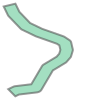

In [6]:
def get_aoi(self,buffersize=None, std_multiplicator = 1):
    """ get a coarse aoi of the reach buffered by the given parameter or the width plus four times the width standard deviation"""
    if buffersize is None:
        buffersize = self.width + std_multiplicator * self.width_std
       
    centerline_wgs84 = LineString(self.coords[1:-1])
    epsg_utm = Conversions.convert_wgs_to_utm_zone(geometry=centerline_wgs84)
    centerline_utm = Conversions.convert_wgs_geometry_to_utm(centerline_wgs84,epsg_utm)

    centerline_utm = centerline_utm.simplify(tolerance=100)
    aoi_utm = centerline_utm.buffer(buffersize, cap_style=2)
    aoi_wgs84 = Conversions.convert_utm_geometry_to_wgs(aoi_utm, epsg_utm)
    if aoi_wgs84.geom_type != 'Polygon':
        aoi_wgs84 = aoi_wgs84.convex_hull
    return list(aoi_wgs84.exterior.coords)
r.aoi = get_aoi(r, std_multiplicator=0) # For IRIS v1 the std_multiplicator is set to 0
Polygon(r.aoi)

The ATL13 data from MVA is stored in the attribute *features_by_mission*.  
Each feature contains parts of the ATL13 data from a specific beam and day intersecting the reach AOI stored as a pandas DataFrame.  
Below, the ATL13 data of the first feature is shown:

In [5]:
r.features_by_mission['icesat2_gt1l_atl13v5_hf'][0]['data']

,lon,lat,wgs_coord,alongtrack_distance,elev,depth,atl13_slope,jday,strong,geoh07,water_body_id,water_body_type,cloud_flag_asr_atl09,cloud_flag_atm_atl09,layer_flag_atl09,qf_cloud,qf_ice,snow_ice_atl09
0,18.941152,45.631690,"(18.941152, 45.63169)",0.000000,124.902,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
1,18.941118,45.631931,"(18.941118, 45.631930999999994)",26.958228,124.910,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
2,18.941083,45.632184,"(18.941083, 45.632183999999995)",55.253504,124.885,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
3,18.941068,45.632292,"(18.941067999999998, 45.632292)",67.332574,124.844,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
4,18.941061,45.632349,"(18.941060999999998, 45.632349)",73.700747,124.816,11.125,-0.000031,6993.82575,None,44.807,2006069,5,2,1,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,18.932704,45.692577,"(18.932703999999998, 45.692577)",6809.702158,125.127,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
466,18.932696,45.692634,"(18.932696, 45.692634)",6816.077786,125.133,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
467,18.932688,45.692698,"(18.932688, 45.692698)",6823.229007,125.149,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1
468,18.932681,45.692749,"(18.932681, 45.692749)",6828.932330,125.168,14.995,0.000660,6993.82576,None,44.772,2006069,5,1,1,0,NaN,NaN,1


Now, we iterate over all features and apply the function *icesat2_pass_helper*:

In [38]:
def icesat2_pass_helper(self, feature, max_median_deviation : float = 0.05, min_size_to_apply_window : int = 20, window_size : int = 7, debug = False):
    """Helper Function to reject outliers and convert along track slope to along centerline slope"""
    pass_geom = wkt.loads(feature['geometry'])
    centerline = LineString(self.coords)

    #######################################################################################
    ### First Intersection for splitting features if necessary
    intersection = pass_geom.intersection(centerline)
    if intersection.is_empty:
        nearest = nearest_points(pass_geom, centerline)
        ref_point_lon = nearest[0].x
        ref_point_lat = nearest[0].y
    elif intersection.geom_type == 'Point':
        ref_point_lon = intersection.x
        ref_point_lat = intersection.y
    elif intersection.geom_type == 'MultiPoint':
        distances = {}
        for i, point in enumerate(intersection.geoms):
            distances[i] = feature['data'].apply(lambda x: Utilities.openadb_spherical_distance(point.x,point.y,x.lon,x.lat),axis=1)
        df = pd.DataFrame(distances)
        nearest_point = df.idxmin(axis=1)
        data = []
        for i in distances.keys():
            this_index = nearest_point[nearest_point == i]
            new_feature = deepcopy(feature)
            new_feature['data'] = new_feature['data'][new_feature['data'].index.isin(this_index.index)]
            if len(new_feature['data'].lon) < 2:
                continue
            try:
                new_feature['geometry'] = Utilities.linestring_helper(new_feature['data'].lon, new_feature['data'].lat)
                _data = icesat2_pass_helper(self,feature=new_feature,max_median_deviation=max_median_deviation,min_size_to_apply_window=min_size_to_apply_window,window_size=window_size,debug=debug)
            except Exception as e:
                _data = None
            if _data is not None:
                data.append(_data)
        return data
    #######################################################################################

    atl13_pass_data = feature['data']
    epsg_utm = Utilities.convert_wgs_to_utm_zone(lon=ref_point_lon, lat=ref_point_lat)
    ydata = atl13_pass_data.elev - atl13_pass_data.geoh07
    xdata = atl13_pass_data.alongtrack_distance

    #######################################################################################
    ### Outlier Detection

    if ydata.shape[0] > min_size_to_apply_window:
        window_median = ydata.rolling(window_size,min_periods=int(np.floor(window_size/2)),center=True).median()
        median_flags = (window_median - ydata).abs() <= max_median_deviation # False : AMD Outlier
    else:
        median_flags = (ydata - ydata.median()) <= max_median_deviation # False : AMD Outlier
    
    type_flags = True #atl13_pass_data.water_body_type.isin([2,5,6]) # Allowed Values: Reservoir, River, Estuary -> False : Type Outlier
    cloud_flags = atl13_pass_data.cloud_flag_asr_atl09.isin([0,1,2,3]) # -> False: Cloud Outlier
    ice_flags = atl13_pass_data.snow_ice_atl09.isin([0,1]) # -> False: Ice Outlier
    flags = type_flags & median_flags & cloud_flags & ice_flags # False : Type, Cloud, Ice, and AMD Outlier
    
    atl13_pass_data.loc[:,"type_flag"] = type_flags
    atl13_pass_data.loc[:,"median_flag"] = median_flags
    atl13_pass_data.loc[:,"cloud_flag"] = cloud_flags
    atl13_pass_data.loc[:,"ice_flags"] = ice_flags
    
    xdata_ice_outlier = xdata.loc[~ice_flags]
    ydata_ice_outlier = ydata.loc[~ice_flags]

    amd_xdata_outlier = xdata.loc[~flags] # For Debug Plot
    amd_ydata_outlier = ydata.loc[~flags] # For Debug Plot
    xdata = xdata.loc[flags]
    ydata = ydata.loc[flags]
    
    if xdata.shape[0] < 2:
        'No Data after AMD and Type Outlier removal'
        return None
    
    clusters = (xdata.diff() > 500).cumsum()
    cluster_flags = clusters == clusters.value_counts().idxmax() # False: Cluster Outlier (Only longest Cluster is used)

    cluster_xdata_outlier = xdata.loc[~cluster_flags] # For Debug Plot
    cluster_ydata_outlier = ydata.loc[~cluster_flags] # For Debug Plot
    xdata = xdata.loc[cluster_flags]
    ydata = ydata.loc[cluster_flags]

    atl13_pass_data.loc[:,"cluster_flag"] = atl13_pass_data.index.isin(xdata.index) #cluster_flags

    if xdata.shape[0] < 2:
        'No Data after Cluster Outlier removal'
        return None

    #######################################################################################
    ###  Position and Angle Determination
    pass_geom = Utilities.validate_geometry(LineString(atl13_pass_data[atl13_pass_data.cluster_flag.fillna(False)].wgs_coord.to_list()))
    intersection = pass_geom.intersection(centerline)
    if intersection.is_empty:
        nearest = nearest_points(pass_geom, centerline)
        ref_point_lon = nearest[0].x
        ref_point_lat = nearest[0].y
    elif intersection.geom_type == 'Point':
        ref_point_lon = intersection.x
        ref_point_lat = intersection.y
    elif intersection.geom_type == 'MultiPoint':
        raise SWORDException('Feature should be split')
    atl13_pass_data.loc[:,'ref_distance'] = Utilities.great_circle_dist(atl13_pass_data.lon.to_numpy(), atl13_pass_data.lat.to_numpy(), ref_point_lon, ref_point_lat) * 1000
    x0 = atl13_pass_data.alongtrack_distance.loc[atl13_pass_data.ref_distance.idxmin()]
    postion = self.get_reach_position_of_closest_cl_point(ref_point_lon, ref_point_lat)
    node_id = self.search_reach_id(lon=ref_point_lon, lat=ref_point_lat, return_node=True)
    normal = self.get_node_normal(node_id, pointing='straight')
    normal_utm = Utilities.convert_wgs_geometry_to_utm(normal, epsg_utm)
    normal_coords = np.asarray(Utilities.get_geom_coordinates(normal_utm))
    pass_geom_utm = Utilities.convert_wgs_geometry_to_utm(pass_geom, epsg_utm)
    pass_coords = np.asarray(Utilities.get_geom_coordinates(pass_geom_utm))
    
    normal_vector = normal_coords[-1] - normal_coords[0]
    pass_vector = pass_coords[-1] - pass_coords[0]
    u, v = pass_vector, normal_vector
    u_norm = np.sqrt(sum(u*u))
    v_norm = np.sqrt(sum(v*v))
    dot = np.dot(u, v)

    #######################################################################################
    ### This Block handles pass height estmate using SVR based on DAHITI approach and SVR outlier rejection
    limit = .05
    distances = np.abs(xdata - x0)
    distance_weights = 1./np.where(distances==0,1,distances)
    xscaler = StandardScaler() # SVR works better when data is scaled
    yscaler = StandardScaler()
    xscaler.fit(xdata.to_numpy().reshape(-1, 1))
    yscaler.fit(ydata.to_numpy().reshape(-1, 1))
    xscaled = xscaler.transform(xdata.to_numpy().reshape(-1, 1))
    yscaled = yscaler.transform(ydata.to_numpy().reshape(-1, 1))
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Liblinear failed to converge, increase the number of iterations.')
        svr = LinearSVR(random_state=0,max_iter=1e6)
        svr.fit(xscaled,np.ravel(yscaled),sample_weight=distance_weights)
    y_predict = yscaler.inverse_transform(svr.predict(xscaled))
    y_deviation = (ydata - y_predict).abs()
    svr_flags = y_deviation <= limit
    y_predict = y_predict[svr_flags]
    if y_predict.size > 0:
        svr_elev = np.average(ydata[svr_flags],weights=distance_weights[svr_flags])
        median_elev = np.median(ydata)
    else:
        svr_elev = np.nan
        median_elev = np.nan

    svr_xdata_outlier = xdata.loc[~svr_flags] # For Debug Plot
    svr_ydata_outlier = ydata.loc[~svr_flags] # For Debug Plot
    xdata = xdata[svr_flags]
    ydata = ydata[svr_flags]
    width = np.max(xdata) - np.min(xdata)
    atl13_pass_data.loc[:,'svr_flag'] = atl13_pass_data.index.isin(xdata.index)
    atl13_pass_data.loc[:,'rejected'] = ~(atl13_pass_data.svr_flag & atl13_pass_data.cluster_flag & atl13_pass_data.median_flag & atl13_pass_data.type_flag)

    if xdata.shape[0] < 2:
        'No Data after SVR Outlier removal'
        return None

    #######################################################################################
    ### This Block handles the conversion from atl13 along track slope to along river centerline slope
    dot_crossing_angle_deg = np.rad2deg(np.arccos(dot/(u_norm * v_norm)))
    if dot != 0 and xdata.size > 1: # orthogonal flying
        tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
        ts = tinv(0.05, len(xdata)-2)
        slope, intercept, r, p, se = stats.linregress(xdata, ydata)
        slope_confidence = ts*se 
        dh = -1 * (u_norm * slope)
        proj_of_u_on_v = (dot/v_norm**2)*v
        l = np.sqrt(sum(proj_of_u_on_v**2))
        adjusted_custom_along_track_slope = (dh/l) * np.sign(dot)
    else:
        adjusted_custom_along_track_slope = np.nan
        slope, intercept, r, p, se = np.nan,np.nan,np.nan,np.nan,np.nan
        slope_confidence = np.nan
    
    #######################################################################################

    date_object = Conversions.julianDayDate(np.nanmean(atl13_pass_data.jday))
    date = datetime.datetime(year=date_object["year"], month=date_object["month"], day=date_object["day"], hour=date_object["hour"], minute=date_object["minute"])
            
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore')
        return {
            'date': date.date(),
            'timestamp': date,
            'mission': feature['mission'],
            'position': postion,
            'lon': ref_point_lon,
            'lat': ref_point_lat,
            'median_elev': median_elev,
            'svr_elev' : svr_elev,
            'elev' : svr_elev if svr_elev is not None else median_elev,
            'elev_std': atl13_pass_data.elev[~atl13_pass_data.rejected].std(),
            'atl13_slope': atl13_pass_data.atl13_slope[~atl13_pass_data.rejected].median(),
            'min_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].min(),
            'max_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].max(),
            'median_depth': atl13_pass_data.depth[~atl13_pass_data.rejected].median(),
            'water_body_ids' : atl13_pass_data.water_body_id[~atl13_pass_data.rejected].unique(),
            'water_body_types' : atl13_pass_data.water_body_type[~atl13_pass_data.rejected].unique(),
            'hf_data': atl13_pass_data,
            'custom_along_track_slope' : slope,
            'custom_along_track_slope_err': se,
            'custom_along_track_slope_abs_rvalue': np.abs(r),
            'custom_along_track_slope_pvalue': p,
            'adjusted_custom_along_track_slope' : adjusted_custom_along_track_slope,
            'dot_crossing_angle_deg' : dot_crossing_angle_deg,
            'node_id' : node_id,
            'width' : width,
            'slope_confidence': slope_confidence,
            }

icesat2_data = []
def rec_append(items):
    # Helper Function for nested data
    if isinstance(items,list):
        for item in items:
            rec_append(item)
    else:
        icesat2_data.append(items)

for features in tqdm(list(r.features_by_mission.values()), desc=f'Estimating ICESat-2 Heights and Along Slope for Reach {r.reach_id} by beam', leave=False):
    for feature in features:
        if feature['data'].empty:
            continue
        data = icesat2_pass_helper(r, feature)
        if data is None:
            continue
        if isinstance(data, list):
            rec_append(data)
        else:
            icesat2_data.append(data)
r.icesat2_data = pd.DataFrame(icesat2_data)

The above block rejected outliers and created the r.icesat2_data attribute containing all features (independent intersections with the river).  
It also computed the along-track slope, its confidence interval, and the feature positions and median elevations required for the across track approach.

Now, using the *icesat2_slope_helper* below, the final along-track and across-track slopes are calculated:

In [40]:
def icesat2_slope_helper(self, min_distance : float, along_angle_th = None, along_conf_th = None):
    mean_across_slope_by_date = {}
    mean_across_std_by_date = {}
    across_slopes_by_date = {}
    across_distances_by_date = {}
    mean_along_slope_by_date = {}
    across_x_angles_by_date = {}
    across_y_angles_by_date = {}
    mean_along_angle_by_date = {}
    along_slopes_by_date = {}
    water_body_types_by_date = {}
    water_body_ids_by_date = {}
    date_groups = dict(list(self.icesat2_data.groupby('date')))
    for date, df in date_groups.items():
        if len(df.index) > 1:
            ########### Across Slope
            cols = ['mission','position','elev','median_elev','elev_std','dot_crossing_angle_deg']
            cross = df[cols].merge(df[cols], how='cross')
            ### absolute distance only to remove duplicates to too close observations:
            cross['distance'] = np.abs(cross.position_x - cross.position_y)
            cross = cross[cross['distance'] > min_distance]
            cross = cross.drop_duplicates(subset="distance").reset_index(drop=True)
            if not cross.empty:
                ###
                ### Actual distance
                cross['distance'] = cross.position_x - cross.position_y
                cross['delta_h'] = cross.elev_x - cross.elev_y
                cross['slope'] = cross.delta_h / cross.distance
                cross['weight'] = 1./(cross.elev_std_x + cross.elev_std_y)
                cross = cross[cross['slope'] >= 0]
                try:
                    mean_across_slope_by_date[date] = np.average(cross.slope,weights=cross.weight)
                    mean_across_std_by_date[date] = np.average((cross.elev_std_x + cross.elev_std_y),weights=cross.weight)
                except ZeroDivisionError:
                    mean_across_slope_by_date[date] = np.nanmean(cross.slope)
                    mean_across_std_by_date[date] = np.nanmean((cross.elev_std_x + cross.elev_std_y))
                across_slopes_by_date[date] = cross['slope']
                across_distances_by_date[date] = cross['distance']
                across_x_angles_by_date[date] = cross['dot_crossing_angle_deg_x']
                across_y_angles_by_date[date] = cross['dot_crossing_angle_deg_y']
        if len(df.index) > 0:
            ########### Along Slope
            def is_unique(s):
                a = s.values
                return (a[0] == a).all()
            
            if along_conf_th is not None and along_angle_th is not None:
                df.loc[:,'conf_threshold'] = df['dot_crossing_angle_deg'].apply(Utilities.icesat2_along_get_conf_threshold_by_angle, args=(along_conf_th, along_angle_th))
                df = df[df.slope_confidence * 1e6 < df.conf_threshold]
                if df.empty:
                    continue
            
            p_index = df.adjusted_custom_along_track_slope >= 0
            df.loc[:,'reduced_angle_deg'] = df.dot_crossing_angle_deg.apply(lambda x: 180-x if x > 90 else x)
            if np.sum(p_index) > 0:
                along_slopes_by_date[date] = df.adjusted_custom_along_track_slope
                water_body_types_by_date[date] = is_unique(df.water_body_types.apply(pd.Series).stack().reset_index(drop=True))
                water_body_ids_by_date[date] = is_unique(df.water_body_ids.apply(pd.Series).stack().reset_index(drop=True))
                try:
                    mean_along_slope_by_date[date] = np.average(df.adjusted_custom_along_track_slope[p_index], weights=1./df.reduced_angle_deg[p_index])
                    mean_along_angle_by_date[date] = np.average(df.dot_crossing_angle_deg[p_index], weights=1./df.reduced_angle_deg[p_index])
                except ZeroDivisionError:
                    mean_along_slope_by_date[date] = np.nanmean(df.adjusted_custom_along_track_slope[p_index])
                    mean_along_angle_by_date[date] = np.nanmean(df.dot_crossing_angle_deg[p_index])
            
    return pd.DataFrame({
        "mean_across" : pd.Series(mean_across_slope_by_date),
        "mean_along" : pd.Series(mean_along_slope_by_date),
        "across" : pd.Series(across_slopes_by_date),
        "along" : pd.Series(along_slopes_by_date),
        "mean_across_std" : pd.Series(mean_across_std_by_date),
        "mean_along_angle" : pd.Series(mean_along_angle_by_date),
        "across_distances" : pd.Series(across_distances_by_date),
        "across_angle_x" : pd.Series(across_x_angles_by_date),
        "across_angle_y" : pd.Series(across_y_angles_by_date),
        "unique_water_body_types" : pd.Series(water_body_types_by_date),
        "unique_water_body_ids" : pd.Series(water_body_ids_by_date),
    })

def get_icesat2_slope(self, mva_instance = None, ee_instance = None, min_distance = 1000., debug=False, extend_aoi=False, extend_aoi_on_empty=False, silent=False, along_angle_th = None, along_conf_th = None):
        """
        Convenience function to extract ICESat2 Data from MVA and calculate water surfac slope.
        Sets the icesat2_data, icesat2_slope_data, mean_mixed_slope, mean_across_slope, and mean_along_slope attributes.

        Parameters
        ----------
        mva_instance : Instance of dgfi_if.MVA_IF Class
            Required in case the passes have to be intersected and extracted from mva.

        ee_instance : Instance of dgfi_if.EE_IF Class, optional
            In case the passes have to be intersected and extracted from mva:  
            If given, the JRC Water Occurence > 80 will be used as AOI.  
            Otherwise the standard SWORD AOI will be used (default is None)

        min_distance : float
            Minimum Distance betwen across beams to calculate across slope (default is 1000.)

        debug : bool
            prints debug messages and plots (default is False)
        
        extend_aoi : bool
            Extends AOI to upstream and downstream reaches (default is False)

        extend_aoi_on_empty : bool
            Extends AOI to upstream and downstream reaches if there is no data for the instance reach (default is False)

        silent : bool
            Suppresses any output (default is False)

        along_angle_th : float, optional
            Maximum angle argument for the along track outlier rejection (Recommended is 65, default is None)

        along_conf_th : float, optional
            Maximum slope fit confidence interval argument for the along track outlier rejection (Recommended is 300, default is None)

        Returns
        -------
        None
        """
        if self.icesat2_data.empty:
            self.icesat2_slope_data = pd.DataFrame()
        else:
            self.icesat2_slope_data = icesat2_slope_helper(r,min_distance = min_distance, along_angle_th = along_angle_th, along_conf_th = along_conf_th)
            count = self.icesat2_slope_data.count()

        if "mean_along" in self.icesat2_slope_data:
            try:
                self.mean_along_slope = self.icesat2_slope_data.mean_along.median()
            except Exception as e:
                # logger.warning('Cannot get along slope for reach {self.reach_id}')
                # logger.exception(e, exc_info=True)
                self.mean_along_slope = np.nan
        else:
            self.mean_along_slope = np.nan
        if "mean_across" in self.icesat2_slope_data:
            try:
                self.mean_across_slope = np.average(self.icesat2_slope_data.mean_across.dropna(),weights=1./self.icesat2_slope_data.mean_across_std.dropna())
            except ZeroDivisionError:
                self.mean_across_slope = np.nanmean(self.icesat2_slope_data.mean_across.dropna())
            except Exception:
                print('Cannot get across slope for reach {self.reach_id}')
                # logger.exception(e, exc_info=True)
                self.mean_across_slope = np.nan
        else:
            self.mean_across_slope = np.nan
        if "mean_along" in self.icesat2_slope_data and "mean_across" in self.icesat2_slope_data:
            self.mean_mixed_slope = self.icesat2_slope_data.mean_across.dropna().combine_first(self.icesat2_slope_data.mean_along.dropna()).median()
        else:
            self.mean_mixed_slope = np.nanmean([self.mean_across_slope, self.mean_along_slope])
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    get_icesat2_slope(r,along_angle_th=65,along_conf_th=300)

In [41]:
if "mean_along" in r.icesat2_slope_data and "mean_across" in r.icesat2_slope_data:
    mixed_slope_series = r.icesat2_slope_data.mean_across.dropna().combine_first(r.icesat2_slope_data.mean_along.dropna())
elif 'mean_along' in r.icesat2_slope_data:
    mixed_slope_series = r.icesat2_slope_data.mean_along
elif 'mean_across' in r.icesat2_slope_data:
    mixed_slope_series = r.icesat2_slope_data.mean_across
else:
    mixed_slope_series = None

print('reach_id' , r.reach_id)
print('lon', r.simple_center[0])
print('lat' , r.simple_center[1])
print('across_flag' , False if np.isnan(r.mean_across_slope) else True)
print('along_flag' , False if np.isnan(r.mean_along_slope) else True)
print('combined_flag' , False if np.isnan(r.mean_mixed_slope) else True)
print('avg_across_slope' , r.mean_across_slope * 1e6)
print('avg_along_slope' , r.mean_along_slope * 1e6)
print('avg_combined_slope' , r.mean_mixed_slope * 1e6)
print('min_across_slope' , r.icesat2_slope_data.mean_across.min() * 1e6 if 'mean_across' in r.icesat2_slope_data else np.nan)
print('min_along_slope' , r.icesat2_slope_data.mean_along.min() * 1e6 if 'mean_along' in r.icesat2_slope_data else np.nan)
print('min_combined_slope' , mixed_slope_series.min() * 1e6 if mixed_slope_series is not None else np.nan)
print('max_across_slope' , r.icesat2_slope_data.mean_across.max() * 1e6 if 'mean_across' in r.icesat2_slope_data else np.nan)
print('max_along_slope' , r.icesat2_slope_data.mean_along.max() * 1e6 if 'mean_along' in r.icesat2_slope_data else np.nan)
print('max_combined_slope' , mixed_slope_series.max() * 1e6 if mixed_slope_series is not None else np.nan)
print('std_across_slope' , r.icesat2_slope_data.mean_across.std() * 1e6 if 'mean_across' in r.icesat2_slope_data else np.nan)
print('std_along_slope' , r.icesat2_slope_data.mean_along.std() * 1e6 if 'mean_along' in r.icesat2_slope_data else np.nan)
print('std_combined_slope' , mixed_slope_series.std() * 1e6 if mixed_slope_series is not None else np.nan)
print('n_across_slope' , r.icesat2_slope_data.mean_across.shape[0] if 'mean_across' in r.icesat2_slope_data else 0)
print('n_along_slope' , r.icesat2_slope_data.mean_along.shape[0] if 'mean_along' in r.icesat2_slope_data else 0)
print('n_combined_slope' , mixed_slope_series.shape[0] if mixed_slope_series is not None else 0)
print('min_date_across_slope' , r.icesat2_slope_data.mean_across.dropna().index.min() if 'mean_across' in r.icesat2_slope_data else np.nan)
print('min_date_along_slope' , r.icesat2_slope_data.mean_along.dropna().index.min() if 'mean_along' in r.icesat2_slope_data else np.nan)
print('min_date_combined_slope' , mixed_slope_series.index.min() if mixed_slope_series is not None else np.nan)
print('max_date_across_slope' , r.icesat2_slope_data.mean_across.dropna().index.max() if 'mean_across' in r.icesat2_slope_data else np.nan)
print('max_date_along_slope' , r.icesat2_slope_data.mean_along.dropna().index.max() if 'mean_along' in r.icesat2_slope_data else np.nan)
print('max_date_combined_slope' , mixed_slope_series.index.max() if mixed_slope_series is not None else np.nan)

reach_id 22791100061
lon 18.93469800034848
lat 45.667934381764546
across_flag True
along_flag True
combined_flag True
avg_across_slope 45.46945176255353
avg_along_slope 51.13468066437649
avg_combined_slope 46.15083558441717
min_across_slope 35.411036739409425
min_along_slope 12.007751614902137
min_combined_slope 12.007751614902137
max_across_slope 52.39182837868987
max_along_slope 109.57663399802425
max_combined_slope 109.57663399802425
std_across_slope 5.864640672545181
std_along_slope 35.13865530340808
std_combined_slope 23.25847476120308
n_across_slope 11
n_along_slope 11
n_combined_slope 11
min_date_across_slope 2019-02-24
min_date_along_slope 2019-02-24
min_date_combined_slope 2019-02-24
max_date_across_slope 2022-05-19
max_date_along_slope 2022-05-19
max_date_combined_slope 2022-05-19
